In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import rotate, adjust_brightness, affine, resize
import random
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os

train_dir = "/kaggle/input/sudoku-digit-classification/data_v2/train_data"
test_dir = "/kaggle/input/sudoku-digit-classification/data_v2/test_data"
val_dir = "/kaggle/input/sudoku-digit-classification/data_v2/validation_data"

def create_dataset(img_dir):
    images, labels = [], []
    for i in range(10):
        img_path = os.path.join(img_dir, str(i))
        for img_file in os.listdir(img_path):
            img = cv2.imread(os.path.join(img_path, img_file), cv2.IMREAD_GRAYSCALE)
            img = torch.tensor(img, dtype=torch.float32)
            img = resize(img.unsqueeze(0), [28, 28]).squeeze(0)
            images.append(img)
            labels.append(i)

    return images, labels
        
train_images, train_labels = create_dataset(train_dir)
test_images, test_labels = create_dataset(test_dir)
val_images, val_labels = create_dataset(val_dir)


In [3]:
class DigitDataset(Dataset):
    def __init__(self, images, labels, augment=False):
        self.images = torch.tensor(images, dtype=torch.float32)
        self.images = self.images / 255.0  # Normalize to [0,1]
        self.images = resize(self.images, [28, 28])  # (N,28,28)
        self.labels = torch.tensor(labels, dtype=torch.int8) 
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def _augment_image(self, img):
        # img should be torch tensor shape (1,32,32)
        if random.random() < 0.5:
            angle = random.uniform(-5, 5)
            img = rotate(img, angle)

        if random.random() < 0.5:
            dx = random.randint(-2, 2)
            dy = random.randint(-2, 2)
            scale = random.uniform(0.8, 1.2)
            img = affine(img, angle=0, translate=[dx, dy], scale=scale, shear=[0.0])

        if random.random() < 0.5:
            factor = random.uniform(0.8, 1.2)
            img = adjust_brightness(img, factor)

        return img

    def __getitem__(self, idx):
        img = self.images[idx].clone().detach().float()
        img = img.unsqueeze(0)  # (1,32,32)
        label = torch.tensor(int(self.labels[idx]), dtype=torch.long)

        if self.augment:
            img = self._augment_image(img)

        return img, label

In [4]:
class CNNDigitClassifier(nn.Module):
    """
    Convolutional Neural Network for digit classification in Sudoku.

    Expects grayscale input images of size 28x28.
    Outputs logits for 10 classes (digits 0-9).
    """
    def __init__(self, num_classes: int = 10):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64x14x14

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 128x7x7
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [5]:
batch_size = 128
epochs = 100
lr = 1e-3
num_classes = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
train_ds = DigitDataset(np.array(train_images), np.array(train_labels), augment=True)
test_ds = DigitDataset(np.array(test_images), np.array(test_labels), augment=True)
val_ds = DigitDataset(np.array(val_images), np.array(val_labels), augment=True)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


In [7]:
model = CNNDigitClassifier(num_classes=num_classes).to(device)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [9]:
import copy

patience = 20
best_loss = float('inf')
best_model = copy.deepcopy(model.state_dict())

for epoch in range(1, epochs+1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    print(f"Epoch {epoch}: loss={train_loss:.4f} acc={train_acc:.4f}")

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)

            val_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    print(f"Val: loss={val_loss:.4f} acc={val_acc:.4f}\n")

    if val_loss < best_loss:
        best_loss = val_loss
        best_model = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_model)

Epoch 1: loss=2.5895 acc=0.1248
Val: loss=2.2850 acc=0.1296

Epoch 2: loss=2.1815 acc=0.1889
Val: loss=2.1456 acc=0.2500

Epoch 3: loss=2.0842 acc=0.2256
Val: loss=2.0820 acc=0.2870

Epoch 4: loss=1.9444 acc=0.2964
Val: loss=1.8698 acc=0.3519

Epoch 5: loss=1.7250 acc=0.3777
Val: loss=1.5262 acc=0.5370

Epoch 6: loss=1.4497 acc=0.4734
Val: loss=1.4451 acc=0.5648

Epoch 7: loss=1.3007 acc=0.5306
Val: loss=1.2491 acc=0.5833

Epoch 8: loss=1.1890 acc=0.5710
Val: loss=1.2793 acc=0.6019

Epoch 9: loss=1.0585 acc=0.6279
Val: loss=0.8838 acc=0.6667

Epoch 10: loss=0.9425 acc=0.6707
Val: loss=0.9370 acc=0.7222

Epoch 11: loss=0.9392 acc=0.6721
Val: loss=0.8765 acc=0.7037

Epoch 12: loss=0.8313 acc=0.7131
Val: loss=0.9151 acc=0.7037

Epoch 13: loss=0.7702 acc=0.7285
Val: loss=0.8675 acc=0.7593

Epoch 14: loss=0.7275 acc=0.7451
Val: loss=0.8691 acc=0.6944

Epoch 15: loss=0.7008 acc=0.7544
Val: loss=0.7541 acc=0.7778

Epoch 16: loss=0.6757 acc=0.7689
Val: loss=0.6535 acc=0.7963

Epoch 17: loss=0.

<All keys matched successfully>

In [10]:
preds = []
labels = []
images = []

model.eval()
with torch.no_grad():
    for x, y in test_dl:
        x = x.to(device)
        pred = model(x).argmax(dim=1).cpu().numpy()
        preds.append(pred)
        labels.append(y.numpy())
        images.append(x.cpu().numpy())

preds = np.concatenate(preds)
labels = np.concatenate(labels)
images = np.concatenate(images)

print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.83      0.71      0.77        28
           1       0.91      1.00      0.95        29
           2       0.90      0.96      0.93        27
           3       0.93      0.93      0.93        28
           4       0.84      0.93      0.89        29
           5       0.93      0.90      0.92        30
           6       0.88      0.97      0.92        30
           7       0.93      0.93      0.93        30
           8       0.86      0.83      0.85        30
           9       1.00      0.82      0.90        28

    accuracy                           0.90       289
   macro avg       0.90      0.90      0.90       289
weighted avg       0.90      0.90      0.90       289



We notice that the hardest digits to classify is zero and eight.

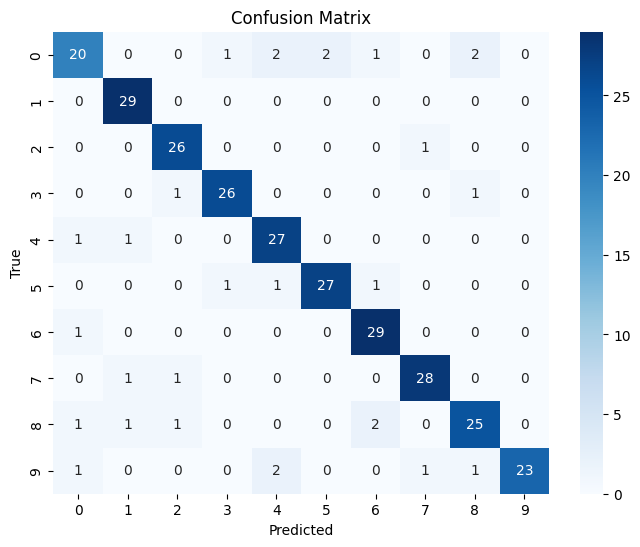

In [11]:
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [12]:
misclassified = preds != labels
print(sum(misclassified))

preds_misclassified = preds[misclassified]
labels_misclassified = labels[misclassified]
images_misclassified = images[misclassified]

29


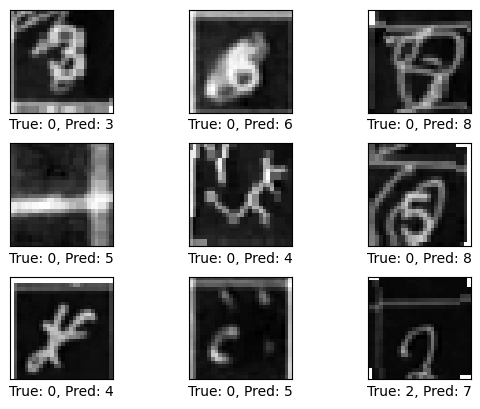

In [13]:
preds_to_plot = preds_misclassified[:9]
labels_to_plot = labels_misclassified[:9]
images_to_plot = images_misclassified[:9]

fig, axes = plt.subplots(3, 3)
axes = axes.flatten()
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for ax, img, pred, label in zip(axes, images_to_plot, preds_to_plot, labels_to_plot):
    img = img.squeeze(0)
    ax.imshow(img, cmap='binary')
    xlabel = f"True: {label}, Pred: {pred}"
    
    # Remove ticks from the plot
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(xlabel)

plt.show()

We see that is hard to classify erased digits as zero. The model predicts the erased digit.

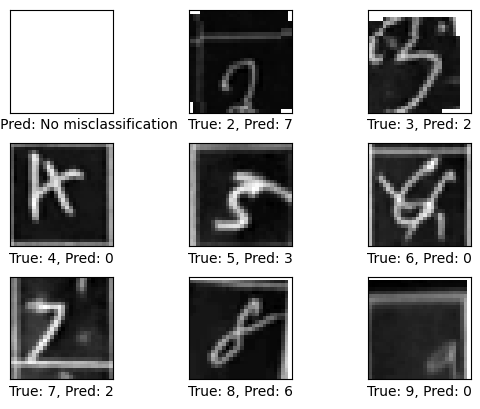

In [14]:
preds_to_plot = []
labels_to_plot = []
images_to_plot = []

for i in range(1, 10):
    for j, label in enumerate(labels_misclassified):
        if i == label:
            labels_to_plot.append(label)
            preds_to_plot.append(preds_misclassified[j])
            images_to_plot.append(images_misclassified[j].squeeze(0))
            break
    else:
        labels_to_plot.append(label)
        preds_to_plot.append("No misclassification")
        images_to_plot.append(np.full((28, 28), 255))

fig, axes = plt.subplots(3, 3)
axes = axes.flatten()
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for ax, img, pred, label in zip(axes, images_to_plot, preds_to_plot, labels_to_plot):
    ax.imshow(img, cmap='binary')
    xlabel = f"True: {label}, Pred: {pred}"
    
    # Remove ticks from the plot
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(xlabel)

plt.show()